<a href="https://colab.research.google.com/github/jimtoberfest/Cointegration_Testing/blob/main/Cointegration_by_hand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# installs and Imports

In [62]:
!pip install yfinance -q

In [63]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import scipy

import statsmodels
import statsmodels.api as sm

import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

#DATA

##SELECTION

In [398]:
tick_list = ['AMD', 'INTC']

In [399]:
start = '2019-03-01'
end = '2022-02-01'

# start = '2019-01-02'
# end = '2021-12-31'

In [400]:
data = yf.download(tick_list, start, end)

[*********************100%***********************]  2 of 2 completed


##Data

In [401]:
data.head()

Adj Close                 Close  ...       Open    Volume          
                  AMD       INTC        AMD  ...       INTC       AMD      INTC
Date                                         ...                               
2019-03-01  23.680000  49.772011  23.680000  ...  53.439999  48084000  18359300
2019-03-04  23.370001  50.369652  23.370001  ...  53.750000  48147700  21706100
2019-03-05  23.500000  50.126862  23.500000  ...  53.849998  35462600  21057700
2019-03-06  22.410000  49.445183  22.410000  ...  53.630001  60479400  14740500
2019-03-07  22.080000  49.118347  22.080000  ...  52.770000  52186300  17803000

[5 rows x 12 columns]

In [402]:
df = data['Adj Close'].copy()

In [403]:
df.head(2)

,AMD,INTC
Date,,
2019-03-01,23.680000,49.772011
2019-03-04,23.370001,50.369652


In [404]:
window = int(len(df) / 2)
window

368

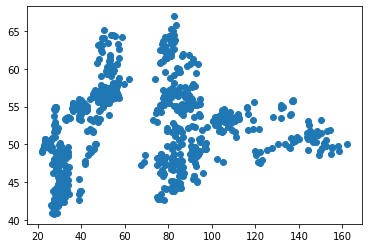

In [405]:
plt.scatter(df['AMD'], df['INTC'])

In [406]:
model = sm.OLS(df['AMD'], df['INTC'])
results = model.fit()
print(results.params[0])
ratio = (round(results.params[0], 0))
print(ratio)

1.3211705111711267
1.0


In [407]:
df['AMD'].head()

Date
2019-03-01    23.680000
2019-03-04    23.370001
2019-03-05    23.500000
2019-03-06    22.410000
2019-03-07    22.080000
Name: AMD, dtype: float64

In [408]:
df['spread'] = df['AMD'] - (round(results.params[0], 1) * df['INTC'])

df.head(3)

,AMD,INTC,spread
Date,,,
2019-03-01,23.680000,49.772011,-41.023614
2019-03-04,23.370001,50.369652,-42.110546
2019-03-05,23.500000,50.126862,-41.664920


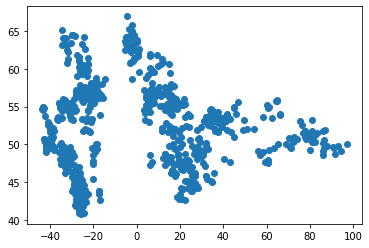

In [409]:
plt.scatter(df['spread'], df['INTC'])

spread mean: 1.3432188516077799


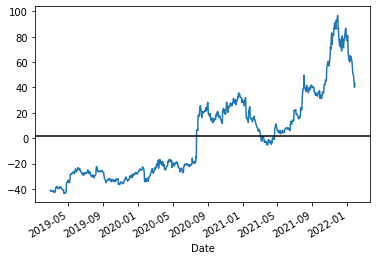

In [410]:
print('spread mean:', df['spread'].mean())

df['spread'].plot()
plt.axhline(df['spread'].mean(), color='k')

In [411]:
adf = adfuller(df.spread, maxlag=1)
print("p-value:",round(adf[1],4))
adf

p-value: 0.7576


(-0.9880542733902757,
 0.7575962575026436,
 0,
 735,
 {'1%': -3.4392782790913206,
  '10%': -2.568868260909806,
  '5%': -2.865480319267325},
 3388.3057008817864)

In [412]:
c_1 = ts.coint(df['AMD'], df['INTC'])
c_1

(-1.2447247234847576,
 0.8457971965281603,
 array([-3.91140261, -3.34445569, -3.05022538]))

##Coint and/or Stationary

In [413]:
print("ADF p-value:",round(adf[1],4), '\n')

print('Coint p-value:', round(c_1[1], 3),'\n')

'spread is NOT cointegrated:' if c_1[1] > .05 else 'spread IS COINTEGRATED'


ADF p-value: 0.7576 

Coint p-value: 0.846 



'spread is NOT cointegrated:'

## Trading Calcs

### Features

In [414]:
window = 30   #SELECT ROLLING WINDOW


df['ratio'] = ratio
df['mean_'+ str(window)] = df['spread'].rolling(window=window).mean()
df['std_'+ str(window)] = df['spread'].rolling(window=window).std()
df['z_score_'+ str(window)] = (df['spread'] - df['mean_'+ str(window)]) / df['std_'+ str(window)]

### Current Value

In [415]:
df.tail(5)

,AMD,INTC,spread,ratio,mean_30,std_30,z_score_30
Date,,,,,,,
2022-01-24,116.529999,51.939999,49.008001,1.0,69.772667,9.942022,-2.088576
2022-01-25,111.129997,51.000000,44.829997,1.0,68.840900,10.912661,-2.200279
2022-01-26,110.709999,51.689999,43.513001,1.0,67.998000,11.852085,-2.065881
2022-01-27,102.599998,48.049999,40.134999,1.0,66.969500,12.877869,-2.083769
2022-01-28,105.239998,47.730000,43.190998,1.0,65.721566,13.315095,-1.692107


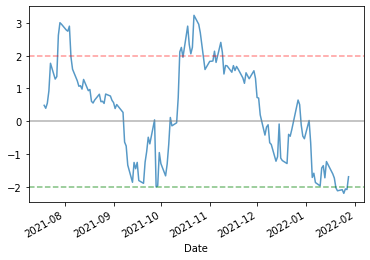

In [416]:
df['z_score_'+ str(window)][600:].plot(alpha=.75)

plt.axhline(0.0, color='grey', linestyle= '-', alpha=.6)
plt.axhline(2.0, color='r', linestyle= '--', alpha=.4)
plt.axhline(-2.0, color='g', linestyle= '--', alpha=.5)

# TPAR (backtesting...)


Trigger Principal Action Result

In [417]:
lag = 1

actions = {'S':-1, 'B': 1, 'C':'C', 'N': 0, np.nan:0}

positions = {'X1':0, 'X2':0}

limit_X1 = 100.0

volume_factor = 1.0


In [418]:
def trigger(zscore, threshold=2.0):
  # event = 0
  if zscore > threshold:
    event = 'S'
  elif zscore < (threshold * -1):
    event = 'B'
  elif abs(zscore) <= (.3):
    event = 'C'  # close
  else:
    event = 'N'  # no event
  return event

In [419]:
def weighted_trades(direction, trade, spread):
  '''
  1 for buys, -1 for sells
  '''
  dir_sign = np.sign(direction) * 1
  trade_sign = np.sign(trade) * 1
  

  if dir_sign == trade_sign:
    event = abs(trade) * spread
    volume = abs(trade)
  else:
    event = 0
    volume = 0

  return event, volume


In [420]:
def action(trigger, X1='X1'):
  trade = [actions[trigger]]
  return trade




In [421]:
df['trigger'] = df.apply(lambda x:  trigger(x['z_score_'+ str(window)] ), axis = 1)
df['trigger_lag'] = df['trigger'].shift(lag)


In [422]:
# for i in range(len(df)):
#   print(i)
#   print(df.iloc[i]['track'], df.iloc[i]['season'])
#   SEM(df.iloc[i]['rider'], df.iloc[i]['rider_ahead'], df.iloc[i]['rider_behind'], riders, riders)

### Walk Thru Loop

In [423]:

#FOR EACH ROW:
# Check Dictionary, positions
# Check Stop / Close conditions
# ACTION X1, from trigger_lag
# derive ACTION X2 from X1
# Update Dictionary, positions




trades_X1 = []
spread_pos = []

for i in range(len(df)):
  curr_position = positions['X1']
  
  if df.iloc[i]['trigger_lag'] == 'C':
    trade = trade =  curr_position * -1
  
  elif abs(curr_position) >= limit_X1:
    trade = 0
  
  else:
    trade = actions[df.iloc[i]['trigger_lag']] * volume_factor
  
  # Update List
  trades_X1.append(trade)
  
  # Update Dictionary
  positions['X1'] = trade + positions['X1']
  spread_pos.append(positions['X1'])

  


In [424]:
df['curr_pos'] = spread_pos

In [425]:

df['trade_X1'] = trades_X1
df['trade_X2'] = (df['trade_X1'] * -1) * df['ratio']

In [426]:
df['spread_wt_buys_volume'] = df.apply(lambda x:  weighted_trades(1, x['trade_X1'],x['spread'])[1], axis = 1)
df['spread_wt_buys'] = df.apply(lambda x:  weighted_trades(1, x['trade_X1'],x['spread'])[0], axis = 1)

df['spread_wt_sells_volume'] = df.apply(lambda x:  weighted_trades(-1, x['trade_X1'],x['spread'])[1], axis = 1)
df['spread_wt_sells'] = df.apply(lambda x:  weighted_trades(-1, x['trade_X1'],x['spread'])[0], axis = 1)

In [427]:
x1_total_volume = (df['spread_wt_buys_volume'].sum())

print(df['spread_wt_buys_volume'].sum())
print(df['spread_wt_sells_volume'].sum())

87.0
81.0


In [428]:
buys = (df['spread_wt_buys'].sum()) / (df['spread_wt_buys_volume'].sum())

In [429]:
sells = (df['spread_wt_sells'].sum()) / (df['spread_wt_sells_volume'].sum())

In [430]:
print(df['curr_pos'].min())
print(df['curr_pos'].max())

-16.0
7.0


### Profit

In [431]:
round(sells - buys,2)

-7.85

In [432]:
profit = round(sells - buys,2) * x1_total_volume
profit

-682.9499999999999

In [433]:
fees = x1_total_volume = (df['spread_wt_buys_volume'].sum()) * 2 * 1.25
fees

217.5

In [434]:
# Profit - Fees

profit - fees

-900.4499999999999

In [435]:
# MARGIN ? 

(80.00 * limit_X1) 

8000.0

In [436]:
# ROM


round(sells - buys,2) * x1_total_volume / (80.00 * limit_X1)


-0.213421875

In [437]:
find = 600

df[find:find + 50]

df.tail(10)

,AMD,INTC,spread,ratio,mean_30,std_30,z_score_30,trigger,trigger_lag,curr_pos,trade_X1,trade_X2,spread_wt_buys_volume,spread_wt_buys,spread_wt_sells_volume,spread_wt_sells
Date,,,,,,,,,,,,,,,,
2022-01-14,136.880005,55.700001,64.470004,1.0,73.305934,7.189204,-1.229055,N,N,0.0,0.0,-0.0,0.0,0.000000,0.0,0.0
2022-01-18,131.929993,54.759998,60.741995,1.0,72.664500,7.427244,-1.605240,N,N,0.0,0.0,-0.0,0.0,0.000000,0.0,0.0
2022-01-19,128.270004,53.619999,58.564006,1.0,72.190867,7.860501,-1.733587,N,N,0.0,0.0,-0.0,0.0,0.000000,0.0,0.0
2022-01-20,121.889999,52.040001,54.237998,1.0,71.448500,8.466898,-2.032681,B,N,0.0,0.0,-0.0,0.0,0.000000,0.0,0.0
2022-01-21,118.809998,52.040001,51.157996,1.0,70.554933,9.143018,-2.121503,B,B,1.0,1.0,-1.0,1.0,51.157996,0.0,0.0
2022-01-24,116.529999,51.939999,49.008001,1.0,69.772667,9.942022,-2.088576,B,B,2.0,1.0,-1.0,1.0,49.008001,0.0,0.0
2022-01-25,111.129997,51.000000,44.829997,1.0,68.840900,10.912661,-2.200279,B,B,3.0,1.0,-1.0,1.0,44.829997,0.0,0.0
2022-01-26,110.709999,51.689999,43.513001,1.0,67.998000,11.852085,-2.065881,B,B,4.0,1.0,-1.0,1.0,43.513001,0.0,0.0
2022-01-27,102.599998,48.049999,40.134999,1.0,66.969500,12.877869,-2.083769,B,B,5.0,1.0,-1.0,1.0,40.134999,0.0,0.0


In [438]:
'''
For 100 lots of BDX on this spread the total margin is $7.5k.




'''

'\nFor 100 lots of BDX on this spread the total margin is $7.5k.\n\n\n\n\n'

In [439]:
# df['running_X1'] = 
# df['running_X2'] = 

# df['trigger'] = df.apply(lambda x:  trigger(x['z_score_'+ str(window)] ), axis = 1) 
# # df['action_X1'] = df['trigger'].apply(lambda x: actions[x] if actions[x] != 'C' else 0)
# # df['action_X1'] = df['trigger'].apply(lambda x: actions[x])

# df['action_X1'] = df.apply(lambda x:  action(x['trigger']), axis = 1)
# df['action_X2'] = df['action_X1'] * ratio * -1

In [440]:
# df['logg'] = np.log(df['spread'] / df['spread'].shift(lag))
# df['logg'].fillna(0.0, inplace=True)
# df['logg_pos'] = df['logg'] * df['curr_pos']
# df['myR'] = df['logg_pos'].cumsum().apply(np.exp)

In [441]:
df[df['trigger_lag']=='B']

,AMD,INTC,spread,ratio,mean_30,std_30,z_score_30,trigger,trigger_lag,curr_pos,trade_X1,trade_X2,spread_wt_buys_volume,spread_wt_buys,spread_wt_sells_volume,spread_wt_sells
Date,,,,,,,,,,,,,,,,
2019-04-18,27.680000,54.618484,-43.324030,1.0,-40.329230,1.596839,-1.875455,N,B,1.0,1.0,-1.0,1.0,-43.324030,0.0,0.0
2019-07-25,33.669998,49.005768,-30.037500,1.0,-27.635877,1.413289,-1.699316,N,B,1.0,1.0,-1.0,1.0,-30.037500,0.0,0.0
2019-08-01,29.860001,46.506622,-30.598608,1.0,-28.221438,1.621617,-1.465926,N,B,2.0,1.0,-1.0,1.0,-30.598608,0.0,0.0
2019-09-10,30.230000,49.015045,-33.489559,1.0,-27.594507,2.744955,-2.147595,B,B,1.0,1.0,-1.0,1.0,-33.489559,0.0,0.0
2019-09-11,29.760000,49.932549,-35.152313,1.0,-27.790395,3.060603,-2.405381,B,B,2.0,1.0,-1.0,1.0,-35.152313,0.0,0.0
2019-09-12,30.209999,50.140636,-34.972828,1.0,-27.913121,3.272310,-2.157408,B,B,3.0,1.0,-1.0,1.0,-34.972828,0.0,0.0
2019-09-13,30.690001,49.696075,-33.914898,1.0,-28.023664,3.418889,-1.723143,N,B,4.0,1.0,-1.0,1.0,-33.914898,0.0,0.0
2019-10-28,33.689999,53.687645,-36.103940,1.0,-33.278063,1.123450,-2.515356,B,B,1.0,1.0,-1.0,1.0,-36.103940,0.0,0.0
2019-10-29,33.029999,53.290382,-36.247498,1.0,-33.389999,1.244196,-2.296664,B,B,2.0,1.0,-1.0,1.0,-36.247498,0.0,0.0
